# **Lab 3 - Activity Recognition with Machine Learning**

This notebook implements a machine learning workflow to recognize different physical activities from Respeck sensor data. The dataset includes multiple 30-second recordings of various physical activities (e.g., ascending stairs, shuffle walking, sitting-standing) stored in separate CSV files for each activity.

You will then use the model you develop here and deploy it inside your Android app for live classification.

In this week, you will not have access to the full dataset as of yet. However, you can complete this lab by combining the data that you and your group mates have collected in Coursework 1 as proof-of-concept first for when you eventually receive the full dataset.


# Imports

In [25]:
# Importing libraries that will be used
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM, Attention
from tensorflow.keras.models import Model
from sklearn.utils import resample
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

# Reading Files
Reading files from your dataset

In [26]:
import os

# Print the current working directory
print(os.getcwd())

c:\Users\seanc\OneDrive - University of Edinburgh\Semester 1\PDIOT\CW3\ActivityApp


In [27]:
# Path to Respeck data
your_dataset_path = "./PDIoT2324/Respeck/"

This line uses the glob module to find all file paths that match a specified pattern. The 'glob.glob()' function returns a list of file paths that match the given pattern. `your_dataset_path` should be the directory where your dataset files are located.

The `*` is a wildcard character that matches any string of characters,  so this pattern retrieves all folders in the 'your_dataset_path' directory.

Below is just an example of what your dataset folder can look like. You should refer to the Coursework 3 instructions on what classes your model(s) are expected to be able to classify. Within your dataset directory, there should be subfolders, each representing a class of activity.

In [28]:
glob.glob(your_dataset_path + "/*")

['./PDIoT2324/Respeck\\00_Respeck_Descending stairs_Normal.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Coughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Hyperventilating.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Laughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Normal.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Singing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down back_Talking.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Coughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Hyperventilating.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Laughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Normal.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Singing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on left_Talking.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on stomach_Coughing.csv',
 './PDIoT2324/Respeck\\00_Respeck_Lying down on stomach_Hy

To see the files in each subfolder you can similarly do:

# Functions

## Load list of files in an activity folder

In [29]:
activities = {
    'ascending': 0,
    'shuffleWalking': 1,
    'sittingStanding': 2,
    'miscMovement': 3,
    'normalWalking': 4,
    'lyingBack': 5,
    'lyingLeft': 6,
    'lyingRight': 7,
    'lyingStomach': 8,
    'descending': 9,
    'running': 10
}

social_signals = {
    'breathingNormal': 0,
    'coughing': 1,
    'hyperventilating': 2,
    'other': 3
}


activity_labels = list(activities.keys())
social_signal_labels = list(social_signals.keys())

In [30]:
def load_files_from_folder(folder_path):
    """
    Load all CSV files from a folder and return a list of file paths.

    Parameters:
    folder_path (str): The path to the folder containing CSV files.

    Returns:
    list: A list of file paths for all CSV files in the folder.
    """

    # Initialize an empty list to store the full file paths of the CSV files
    file_paths = []

    # Loop through all the files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file has a .csv extension (ignores other files)
        if file_name.endswith('.csv'):
            # Construct the full file path by joining the folder path and the file name
            full_file_path = os.path.join(folder_path, file_name)

            # Append the full file path to the file_paths list
            file_paths.append(full_file_path)

    # Return the complete list of CSV file paths
    return file_paths

In [31]:
# Function to extract either the activity or the social signal label from the file name
def extract_task(file_name, task):
    """
    Extract the activity or social signal label from a file name.

    Parameters:
    file_name (str): The name of the file containing the label.
    task (str): The task to extract from the file name (e.g., 'activity' or 'social_signal').

    Returns:
    str: The extracted label from the file name.
    """

    # Split the file name by underscores to extract different parts
    file_parts = file_name.split('_')

    # Check if the task is 'activity'
    if task == 'activity':
        # The activity label is the second part of the file name
        label = file_parts[2]
    # Check if the task is 'social_signal'
    elif task == 'social_signal':
        # The social signal label is the third part of the file name
        label = file_parts[3].split(".")[0]

    if label == "sitting" or label == "standing" or label == "Sitting" or label == "Standing":
        label = "sittingStanding"
    
    # For processing the 2024_2025 dataset which has different naming
    if label == "Descending stairs":
        label = "descending"
    
    if label == "Ascending stairs":
        label = "ascending"
    
    if label == "Lying down back":
        label = "lyingBack"
    
    if label == "Lying down on left":
        label = "lyingLeft"
    
    if label == "Lying down on stomach":
        label = "lyingStomach"
    
    if label == "Lying down right":
        label = "lyingRight"

    if label == "Miscellaneous movements":
        label = "miscMovement"

    if label == "Normal walking":
        label = "normalWalking"

    if label == "Running":
        label = "running"

    if label == "Shuffle walking":
        label = "shuffleWalking"

    if label == "Normal":
        label = "breathingNormal"
    
    if label == "Hyperventilating":
        label = "hyperventilating"

    if label == "Coughing":
        label = "coughing"

    if label == "laughing" or label == "talking" or label == "eating" or label == "singing" or label == "Laughing" or label == "Talking" or label == "Eating" or label == "Singing":
        label = "other"

    if task == "activity":
        label = activities[label]
    else:
        label = social_signals[label]
    # Return the extracted label
    return label


## Train and test set split from list of files

In [32]:
def split_files(file_list, test_size=0.2):
    """
    Split the list of files into training and test sets.

    Parameters:
    file_list (list): List of file paths to be split into train and test sets.
    test_size (float): The proportion of files to allocate to the test set.
                       Default is 0.2, meaning 20% of the files will be used for testing.

    Returns:
    tuple:
        - train_files (list): List of file paths for the training set.
        - test_files (list): List of file paths for the test set.
    """

    # Split the file list into training and test sets using train_test_split from scikit-learn
    # test_size defines the proportion of the data to use as the test set (default is 20%)
    # shuffle=True ensures that the files are shuffled randomly before splitting
    train_files, test_files = train_test_split(file_list, test_size=test_size, shuffle=True)

    # Return the train and test file lists
    return train_files, test_files

## Sliding Window

In time series Activity Recognition, a sliding window is a commonly used technique to segment continuous sensor data (such as accelerometer readings) into smaller, fixed-length overlapping or non-overlapping time intervals, or windows. Each window contains a sequence of sensor measurements that represent a short period of time, and this segmented data is used to extract features or make predictions about the activity happening within that window.

### Key Concepts of a Sliding Window
1.   **Window Size:** This refers to the length of each segment or window, typically defined in terms of the number of time steps or the duration (e.g., 2 seconds). The window size should be chosen carefully to capture enough information about the activity without making the window too large.
2.   **Step Size:** The step size determines how far the window moves forward after each step. If the step size is smaller than the window size, the windows will overlap. For example, if the window size is 5 seconds and the step size is 2 seconds, there will be a 3-second overlap between consecutive windows. Overlapping windows provide more data for analysis and can help smooth out predictions by capturing transitional activities.
3.   **Non-Overlapping Windows:** If the step size is equal to the window size, the windows do not overlap. This method provides distinct segments of data but may miss transitional phases between activities.

### Why Sliding Windows for Activity Recognition?

* Segmentation of Continuous Data: Activity recognition systems work with continuous streams of sensor data, and the sliding window helps segment these into manageable pieces to classify activities within specific intervals.

* Context Capturing: Human activities are often complex and spread across time. By using a sliding window, you can capture context across a short duration, which may include transitions or small fluctuations in the activity (e.g., a person moving from sitting to standing).

* Feature Extraction: Within each window, features such as mean, variance, frequency domain features, etc., can be extracted to help classify the activity.

* Real-Time Recognition: In real-time systems, the sliding window allows for continuous monitoring and updating of predictions as new data arrives.



In [33]:
def load_and_apply_sliding_windows(file_paths, window_size, step_size, task):
    """
    Load the data from each file, apply sliding windows, and return the windows and labels.

    Parameters:
    file_paths (list): List of file paths to CSV files. Each file contains sensor data (e.g., accelerometer, gyroscope).
    window_size (int): The size of each sliding window (number of time steps).
    step_size (int): The step size (stride) between consecutive windows.
    label (int or str): The label for the activity corresponding to the folder.
                        This label will be assigned to each sliding window extracted from the data.

    Returns:
    tuple:
        - windows (numpy.ndarray): A 3D array of sliding windows, where each window has the shape
                                   (num_windows, window_size, num_features).
        - labels (numpy.ndarray): A 1D array of labels, where each label corresponds to a sliding window.
    """
    # Initialize lists to store sliding windows and their corresponding labels
    windows = []
    labels = []

    # Loop through each file in the provided file paths
    for file_path in file_paths:
        label = extract_task(file_path, task)
        # Load the CSV file into a pandas DataFrame
        data = pd.read_csv(file_path)

        # Select the columns containing the necessary sensor data (acceleration and gyroscope readings)
        # These columns might vary depending on your dataset's structure
        data = data[['accel_x', 'accel_y', 'accel_z']]

        # Convert the DataFrame into a numpy array for faster processing in the sliding window operation
        data = data.to_numpy()

        # Get the number of samples (rows) and features (columns) in the data
        num_samples, num_features = data.shape

        # Apply sliding windows to the data
        # The range function defines the start of each window, moving step_size increments at a time
        for i in range(0, num_samples - window_size + 1, step_size):
            # Extract a window of size 'window_size' from the current position 'i'
            window = data[i:i + window_size, :]

            # Append the window to the windows list
            windows.append(window)

            # Assign the activity label to the window and append it to the labels list
            labels.append(label)

    # Convert the lists of windows and labels into numpy arrays for efficient numerical operations
    return np.array(windows), np.array(labels)

## Load and Split Train Test for Each Activity Folder

This function processes the sensor data for a specific activity, such as 'walking' or 'running', stored in its respective folder. It splits the data into training and testing sets, applies sliding windows, and labels the windows with the corresponding activity. This function can be used repeatedly for each activity to process and prepare data for training and evaluation.

In [34]:
def process_task(task, label_list, dataset_path, window_size, step_size, test_size=0.2):
    """
    Processes an activity folder by loading the file list, splitting them into
    train and test sets, and applying sliding windows to the files.

    Args:
        activity (str): Name of the activity (folder name). This refers to the specific physical activity
                        like 'walking', 'running', etc.
        label (int): Numeric label corresponding to the activity, used for classification.
        dataset_path (str): Base path where the activity folders are located.
        window_size (int): Size of the sliding window, i.e., the number of time steps included in each window.
                           Default is 50.
        step_size (int): Step size for the sliding window, i.e., how far the window moves along the data.
                         Default is 50 (no overlap between windows).
        test_size (float): Proportion of files to use for testing. Default is 0.2, meaning 20% of files will
                           be allocated to the test set.

    Returns:
        tuple:
            - train_windows (numpy.ndarray): Sliding windows from the training files.
            - train_labels (numpy.ndarray): Corresponding labels for the training windows.
            - test_windows (numpy.ndarray): Sliding windows from the test files.
            - test_labels (numpy.ndarray): Corresponding labels for the test windows.
    """

    # Load all CSV file paths for the given activity from the folder
    file_list = load_files_from_folder(dataset_path)

    # Split the file list into training and testing sets
    # train_files: files used for training
    # test_files: files used for testing
    #train_files, test_files = split_files(file_list, task, test_size=test_size)
    
    # Apply sliding windows to the training files
    # The function 'load_and_apply_sliding_windows' returns the sliding windows (segments) and their corresponding labels
    windows, labels = load_and_apply_sliding_windows(file_list, window_size, step_size, task)

    # Apply sliding windows to the testing files
    #test_windows, test_labels = load_and_apply_sliding_windows(test_files, window_size, step_size, task)

    # Return the sliding windows and their labels for both training and testing sets
    return windows, labels

## Combine Data
The function combines the sliding window data and their corresponding labels from multiple activities (e.g., walking, running, etc.) into single arrays.

In [35]:
def combine_data(train_test_data, data_type):
    """
    Combines the sliding windows and labels from all activities into a single
    array for either training or testing.

    Args:
        train_test_data (dict): Dictionary containing the sliding window data for all activities.
                                Each key in the dictionary corresponds to an activity, and the value is another
                                dictionary with the keys 'train_windows', 'train_labels', 'test_windows', 'test_labels'.
        data_type (str): Either 'train' or 'test' to specify which data to combine (e.g., 'train_windows' or 'test_windows').

    Returns:
        tuple:
            - windows (numpy.ndarray): Concatenated windows from all activities for either training or testing.
            - labels (numpy.ndarray): Concatenated labels corresponding to the windows from all activities.
    """

    # Extract the list of sliding windows for the specified data type (either 'train' or 'test') from each activity
    # For example, if data_type is 'train', it extracts 'train_windows' for all activities
    windows_list = [train_test_data[activity][f'{data_type}_windows'] for activity in train_test_data]

    # Similarly, extract the list of labels corresponding to the windows for each activity
    labels_list = [train_test_data[activity][f'{data_type}_labels'] for activity in train_test_data]

    # Concatenate all the sliding windows into a single numpy array along the first axis (rows)
    # This creates one large array of windows from all the activities combined
    concatenated_windows = np.concatenate(windows_list, axis=0)

    # Concatenate all the labels into a single numpy array along the first axis (rows)
    # The labels are now aligned with the concatenated windows
    concatenated_labels = np.concatenate(labels_list, axis=0)

    # Return the concatenated windows and labels as a tuple
    return concatenated_windows, concatenated_labels

## 1D CNN Model

This function, `build_1d_cnn_model`, creates and compiles a 1D Convolutional Neural Network (CNN) for multi-class classification tasks.

### Function Overview

Input Parameters
* `input_shape`: Specifies the shape of the input data. It represents (timesteps, features), where timesteps refer to the length of the time series (e.g., 50 windows), and features represent the number of measurements in each time step (e.g., accelerometer readings).
* `num_classes`: The number of output classes for the classification problem. For example, if you're classifying six different activities, num_classes would be 6.

Returns
* The function returns a compiled 1D CNN model that is ready to be trained on your data.

<hr>

### Function Breakdown
1.   Model Initialization:
    * `model = Sequential()`: Initializes a Sequential model, which means layers will be stacked on top of each other in a linear fashion.
2.   First Convolutional Layer
    * `Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)`
        * This is the first 1D convolutional layer
        * `filters=64`: The layer applies 64 filters (or kernels) over the input data.
        * `kernel_size=3`: Each filter will cover 3 timesteps at a time (a window of 3).
        * `activation='relu'`: The Rectified Linear Unit (ReLU) activation function introduces non-linearity and helps the model learn complex patterns.
        * `input_shape=input_shape`: Specifies the shape of the input data.
    * `MaxPooling1D(pool_size=2)`: This pooling layer reduces the dimensionality of the data by taking the maximum value from each 2-timestep window (`pool_size=2`). This helps reduce computational complexity and captures the most important features.
3. Second Convolutional Layer:
    * `Conv1D(filters=128, kernel_size=3, activation='relu')`
        * This is the second convolutional layer, similar to the first, but with 128 filters, which allow the network to learn more complex features from the data.
        * `kernel_size=3` and activation='relu' function in the same way as the first Conv1D layer.
    * `MaxPooling1D(pool_size=2)`: Another pooling layer to downsample the output, further reducing the data’s dimensionality.
4. Flattening Layer:
    * `Flattening`: Converts the 2D output of the convolutional and pooling layers into a 1D vector. This is necessary because the next layer is fully connected, and it requires a 1D input.
5. Fully Connected Layer:
    * `Dense(128, activation='relu')`: This is a fully connected layer with 128 units/neurons. Each neuron is connected to every input from the flattened output. The ReLU activation function is used again to introduce non-linearity and help the model learn complex relationships.
6. Dropout Layer:
    * `Dropout(0.5)`: This layer randomly sets 50% of the neurons to zero during training to prevent overfitting. It helps the model generalize better to unseen data.
7. Output Layer:
    * `Dense(num_classes, activation='softmax')`: This is the output layer with num_classes neurons, one for each class in the classification problem. The softmax activation function ensures the output values represent probabilities that sum to 1, useful for multi-class classification.
8. Compiling the model
    * model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        * Optimizer: 'adam': Adam is an optimization algorithm that adjusts the learning rate during training to improve performance.
        * Loss: 'categorical_crossentropy': This loss function is used for multi-class classification problems where the target variable is one-hot encoded (i.e., represented as a vector of 0s and 1s).
        * Metrics: ['accuracy']: The accuracy metric is used to evaluate the model’s performance during training and testing.


In [ ]:
def build_1d_cnn_model(input_shape, num_classes):
    """
    Builds and compiles a 1D CNN model for multi-class classification.

    Args:
        input_shape (tuple): The shape of the input data (timesteps, features).
        num_classes (int): The number of output classes.

    Returns:
        model (Sequential): Compiled 1D CNN model.
    """
    model = Sequential()

    # First Conv1D layer
    # You can try experimenting with different filters, kernel_size values and activiation functions
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    # Second Conv1D layer
    # You can try experimenting with different filters, kernel_size values and activiation functions
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Third Conv1D layer
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(128, activation='relu'))

    # Dropout layer for regularization
    # You can try experimenting with different dropout rates
    model.add(Dropout(0.3))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #  Prints a detailed summary of the model, showing the layers, their output shapes, and the number of trainable parameters
    model.summary()
    return model

# Classification Pipeline

## Step 1: Prepare and Preprocess the Data

In [101]:
# Create the sliding windows and labels for the activity and social signal tasks
#X_activity, y_activity = process_task("activity", activity_labels, your_dataset_path, window_size=100, step_size=50)
X_social_signal, y_social_signal = process_task("social_signal", social_signal_labels, your_dataset_path, window_size=200, step_size=10)

#print(f"Length of data for activity windows: {len(X_activity)} with {len(set(y_activity))} different labels, labels are {y_activity}")
print(f"Length of data for social signal windows: {len(X_social_signal)} with {len(set(y_social_signal))} different labels, labels are {y_social_signal}")

#print(f"X_activity shape: {X_activity.shape}, y_activity shape: {y_activity.shape}")
print(f"X_social_signal shape: {X_social_signal.shape}, y_social_signal shape: {y_social_signal.shape}")


Length of data for social signal windows: 302909 with 4 different labels, labels are [0 0 0 ... 3 3 3]
X_social_signal shape: (302909, 200, 3), y_social_signal shape: (302909,)


Now that each activity has been processed and stored in train_test_data, we need to combine the sliding windows and labels from all activities into unified arrays (one for training and one for testing) for model training.

### One-Hot Encode Labels (for multi-class classification)
If you have more than two classes, you'll need to one-hot encode the labels, especially if your model will use categorical cross-entropy loss.

One-Hot Encoding converts categorical labels into binary vectors (one-hot encoded format). Each class label is represented as a binary vector with 1 for the correct class and 0 for others. This is necessary for training models that use categorical_crossentropy as the loss function, such as a neural network.

In [102]:
# Initialise the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit the OneHotEncoder on the training activity labels and transform them to one-hot encoded format
#y_activity_one_hot = encoder.fit_transform(y_activity.reshape(-1, 1))

y_social_signal_one_hot = encoder.fit_transform(y_social_signal.reshape(-1, 1))

# Transform the test activity labels to one-hot encoded format using the already fitted encoder


# Explanation:
# - y_train_activity_one_hot, y_train_social_signal_one_hot, y_test_activity_one_hot and y_test_social_signal_one_hot are now 2D arrays where each row is a one-hot encoded binary vector corresponding to a class label.
# - The number of columns in the one-hot encoded labels equals the number of unique classes (activities).
# For example, if there are 6 unique activities, the encoded vector will have 6 elements, with a '1' indicating the correct class.

In [103]:
# Print the shapes of the one-hot encoded labels to verify that the transformation was successful
#print(f"y_activity_one_hot shape: {y_activity_one_hot.shape}")
print(f"y_social_signal_one_hot shape: {y_social_signal_one_hot.shape}")

# Explanation of shapes:
# - The shape of y_train_activity_one_hot will be (num_samples, num_classes), where:
#     - num_samples is the number of training windows.
#     - num_classes is the number of unique activities (the length of the one-hot vectors).
# - Similarly, y_test_activity_one_hot will have the same number of columns (num_classes) as y_train_activity_one_hot but will have fewer rows (corresponding to the number of test windows).

y_social_signal_one_hot shape: (302909, 4)


## Step 2: Build the 1D-CNN Model
Call our `build_1d_cnn_model` functionto build our model

In [104]:
# Determine the input shape for the model
#input_shape_activity = (X_activity.shape[1], X_activity.shape[2])
#print(f"Input shape for the activity model: {input_shape_activity}")

input_shape_social_signal = (X_social_signal.shape[1], X_social_signal.shape[2])
print(f"Input shape for the social signal model: {input_shape_social_signal}")

# Determine the number of output classes (num_classes)
num_activity_classes = y_activity_one_hot.shape[1]
num_social_signal_classes = y_social_signal_one_hot.shape[1]

# Build and compile the model
# The function will return a compiled model ready for training
#activity_model = build_1d_cnn_model(input_shape_activity, num_activity_classes)
#social_signal_model = build_1d_cnn_model(input_shape_social_signal, num_social_signal_classes)

Input shape for the social signal model: (200, 3)


## Step 3: Train the CNN Model

Train the 1D CNN model using the training data and validate on the test data. The model will learn to map input sliding windows to their corresponding activity labels.

`model.fit()` is used to train the neural network model. It takes several parameters:
* `X_train`: The input training data (sliding windows), with shape (num_samples, window_size, num_features).
* `y_train_one_hot`: The corresponding one-hot encoded labels for the training data, with shape (num_samples, num_classes).
* `epochs`: Number of times the entire training dataset is passed through the model. You can try adjusting the number of epochs and compare the difference in model performance. In this case, we are training for 20 epochs, meaning the model will see the entire training set 20 times.
* `batch_size`: Number of samples processed before the model's weights are updated. Here, the batch size is set to 32, meaning the model will process 32 samples at a time before updating its parameters.
* `validation_data`: This parameter allows us to evaluate the model's performance on the test data after each epoch.
*`(X_test, y_test_one_hot)`: These are the input test data and corresponding one-hot encoded test labels.

In [105]:
# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialise lists to store the accuracy of each fold
activity_accuracy_list = []
social_signal_accuracy_list = []

# Initialize lists to store the recall for each class for all folds
recall_per_class_per_fold_social_signal = {i: [] for i in range(num_social_signal_classes)}
recall_per_class_per_fold_activity = {i: [] for i in range(num_activity_classes)}


# Initialise lists to store the true and predicted labels for social signals for all folds
all_y_true_social_signal = []
all_y_pred_social_signal = []

# Initialise lists to store the true and predicted labels for activities for all folds
all_y_true_activity = []
all_y_pred_activity = []


In [106]:
fold_no = 1

# Train and Evaluate social signal model
for train_index, val_index in kfold.split(X_social_signal):
    print(f"Training social signal model for fold {fold_no}")

    # Split the data for this fold
    X_train_fold_social_signal, X_val_fold_social_signal = X_social_signal[train_index], X_social_signal[val_index]
    y_train_fold_social_signal, y_val_fold_social_signal = y_social_signal_one_hot[train_index], y_social_signal_one_hot[val_index]

    # Reinitialise the social signal model for each fold
    social_signal_model = build_1d_cnn_model(input_shape_social_signal, num_social_signal_classes)

    history = social_signal_model.fit(X_train_fold_social_signal, y_train_fold_social_signal,
                                        epochs=5, batch_size=64,
                                        validation_data=(X_val_fold_social_signal, y_val_fold_social_signal),
                                        verbose=1)
    
    y_pred_probs_social_signal = social_signal_model.predict(X_val_fold_social_signal)
    y_pred_social_signal = np.argmax(y_pred_probs_social_signal, axis=1)
    y_true_social_signal = np.argmax(y_val_fold_social_signal, axis=1)

    social_signal_report = classification_report(y_true_social_signal, y_pred_social_signal, output_dict=True)
    for i in range(num_social_signal_classes):
        recall_per_class_per_fold_social_signal[i].append(social_signal_report[str(i)]['recall'])

    social_signal_accuracy_list.append(accuracy_score(y_true_social_signal, y_pred_social_signal))

    # Collect predictions and true social signal labels for confusion matrix
    all_y_true_social_signal.extend(y_true_social_signal)
    all_y_pred_social_signal.extend(y_pred_social_signal)

    print(f"Completed training and evaluation for fold {fold_no}")

    # Print recall for each class after each fold
    for i in range(num_social_signal_classes):
        print(f"Recall for class {i} after fold {fold_no}: {recall_per_class_per_fold_social_signal[i][-1]:.4f}")

    fold_no += 1

average_social_signal_accuracy = np.mean(social_signal_accuracy_list)
print(f"Average accuracy for social signal model: {average_social_signal_accuracy:.4f}")

average_recall_per_class_social_signal = {i: np.mean(recall_per_class_per_fold_social_signal[i]) for i in range(num_social_signal_classes)}

for i in range(num_social_signal_classes):
    print(f"The 5-fold cross validation recall of class {i} is {average_recall_per_class_social_signal[i]:.4f}")

Training social signal model for fold 1


c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_153 (Conv1D)             │ (None, 198, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_153               │ (None, 99, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_154 (Conv1D)             │ (None, 97, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_154               │ (None, 48, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_155 (Conv1D)             │ (None, 46, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_155               │ (None, 23, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 5888)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 128)            │       753,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 878,212 (3.35 MB)

 Trainable params: 878,212 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2674/3787 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.6015 - loss: 0.9467

KeyboardInterrupt: 

# Social signal confusion matrix

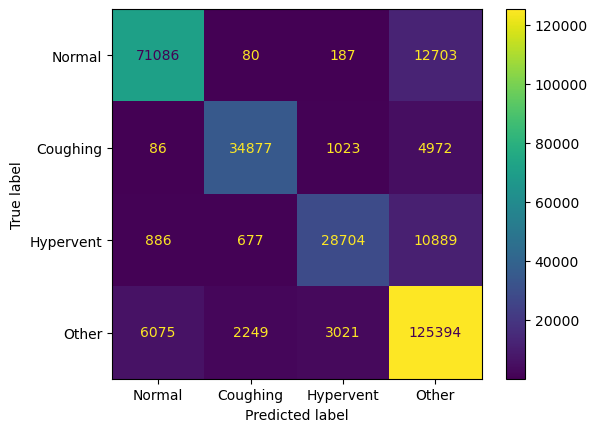

In [ ]:
 # Convert the lists for the confusion matrix to numpy arrays
all_y_true_social_signal = np.array(all_y_true_social_signal)
all_y_pred_social_signal = np.array(all_y_pred_social_signal)

# Generate confusion matrix
cm = confusion_matrix(all_y_true_social_signal, all_y_pred_social_signal)
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Coughing', 'Hypervent', 'Other']).plot()

In [ ]:
# Train and Evaluate activity model
fold_no = 1
for train_index, val_index in kfold.split(X_activity):
    print(f"Training activity model for fold {fold_no}")

    # Split the data for this fold
    X_train_fold_activity, X_val_fold_activity = X_activity[train_index], X_activity[val_index]
    y_train_fold_activity, y_val_fold_activity = y_activity_one_hot[train_index], y_activity_one_hot[val_index]

    # Reinitialise the activity model for each fold
    activity_model = build_1d_cnn_model(input_shape_activity, num_activity_classes)

    history = activity_model.fit(X_train_fold_activity, y_train_fold_activity, 
                                 epochs=10, batch_size=64, 
                                 validation_data=(X_val_fold_activity, y_val_fold_activity), 
                                 verbose=1)
    
    # Predictions and evaluation for activity model
    y_pred_probs_activity = activity_model.predict(X_val_fold_activity)
    y_pred_activity = np.argmax(y_pred_probs_activity, axis=1)
    y_true_activity = np.argmax(y_val_fold_activity, axis=1)

    activity_report = classification_report(y_true_activity, y_pred_activity, output_dict=True)
    for i in range(num_activity_classes):
        recall_per_class_per_fold_activity[i].append(activity_report[str(i)]['recall'])
    activity_accuracy_list.append(accuracy_score(y_true_activity, y_pred_activity))

    # Collect predictions and true social signal labels for confusion matrix
    all_y_true_activity.extend(y_true_activity)
    all_y_pred_activity.extend(y_pred_activity)

    print(f"Completed training and evaluation for fold {fold_no}")

     # Print recall for each class after each fold
    for i in range(num_activity_classes):
        print(f"Recall for class {i} after fold {fold_no}: {recall_per_class_per_fold_activity[i][-1]:.4f}")
    fold_no += 1
    
average_activity_accuracy = np.mean(activity_accuracy_list)
print(f"Average accuracy for activity model: {average_activity_accuracy:.4f}")

average_recall_per_class_activity = {i: np.mean(recall_per_class_per_fold_activity[i]) for i in range(num_activity_classes)}

for i in range(num_activity_classes):
    print(f"The 5-fold cross validation recall of class {i} is {average_recall_per_class_activity[i]:.4f}")

Training activity model for fold 1


c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_135 (Conv1D)             │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_135               │ (None, 49, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_136 (Conv1D)             │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_136               │ (None, 23, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_137 (Conv1D)             │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_137               │ (None, 10, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8501 - loss: 0.5513 - val_accuracy: 0.9195 - val_loss: 0.2651
Epoch 2/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9253 - loss: 0.2623 - val_accuracy: 0.9396 - val_loss: 0.2140
Epoch 3/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9417 - loss: 0.2081 - val_accuracy: 0.9505 - val_loss: 0.1848
Epoch 4/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9505 - loss: 0.1775 - val_accuracy: 0.9542 - val_loss: 0.1747
Epoch 5/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9560 - loss: 0.1600 - val_accuracy: 0.9545 - val_loss: 0.1612
Epoch 6/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9596 - loss: 0.1464 - val_accuracy: 0.9591 - val_loss: 0.1498
Epoch 7/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9598 - loss: 0.1449 - val_accuracy: 0.9611 - val_loss: 0.1484
Epoch 8/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9633 - loss: 0.1292 - 

c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_138 (Conv1D)             │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_138               │ (None, 49, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_139 (Conv1D)             │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_139               │ (None, 23, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_140 (Conv1D)             │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_140               │ (None, 10, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8580 - loss: 0.5570 - val_accuracy: 0.9207 - val_loss: 0.2692
Epoch 2/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9252 - loss: 0.2675 - val_accuracy: 0.9373 - val_loss: 0.2237
Epoch 3/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9397 - loss: 0.2176 - val_accuracy: 0.9525 - val_loss: 0.1761
Epoch 4/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9484 - loss: 0.1882 - val_accuracy: 0.9504 - val_loss: 0.1760
Epoch 5/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9529 - loss: 0.1706 - val_accuracy: 0.9509 - val_loss: 0.1697
Epoch 6/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9563 - loss: 0.1579 - val_accuracy: 0.9554 - val_loss: 0.1543
Epoch 7/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9609 - loss: 0.1410 - val_accuracy: 0.9601 - val_loss: 0.1428
Epoch 8/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9635 - loss: 0.1305 - 

c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_141 (Conv1D)             │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_141               │ (None, 49, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_142 (Conv1D)             │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_142               │ (None, 23, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_143 (Conv1D)             │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_143               │ (None, 10, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8533 - loss: 0.5506 - val_accuracy: 0.9095 - val_loss: 0.2855
Epoch 2/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9217 - loss: 0.2767 - val_accuracy: 0.9341 - val_loss: 0.2258
Epoch 3/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9416 - loss: 0.2170 - val_accuracy: 0.9419 - val_loss: 0.2063
Epoch 4/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9498 - loss: 0.1839 - val_accuracy: 0.9490 - val_loss: 0.1769
Epoch 5/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9560 - loss: 0.1629 - val_accuracy: 0.9507 - val_loss: 0.1762
Epoch 6/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9576 - loss: 0.1548 - val_accuracy: 0.9552 - val_loss: 0.1628
Epoch 7/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9606 - loss: 0.1414 - val_accuracy: 0.9531 - val_loss: 0.1630
Epoch 8/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9637 - loss: 0.1312 - 

c:\Users\seanc\miniconda3\envs\pdiot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_144 (Conv1D)             │ (None, 98, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_144               │ (None, 49, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_145 (Conv1D)             │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_145               │ (None, 23, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_146 (Conv1D)             │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_146               │ (None, 10, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,131 (1.73 MB)

 Trainable params: 453,131 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8515 - loss: 0.5685 - val_accuracy: 0.9260 - val_loss: 0.2672
Epoch 2/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9217 - loss: 0.2792 - val_accuracy: 0.9368 - val_loss: 0.2140
Epoch 3/10
584/930 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9370 - loss: 0.2253

KeyboardInterrupt: 

# Confusion matrix for activity model

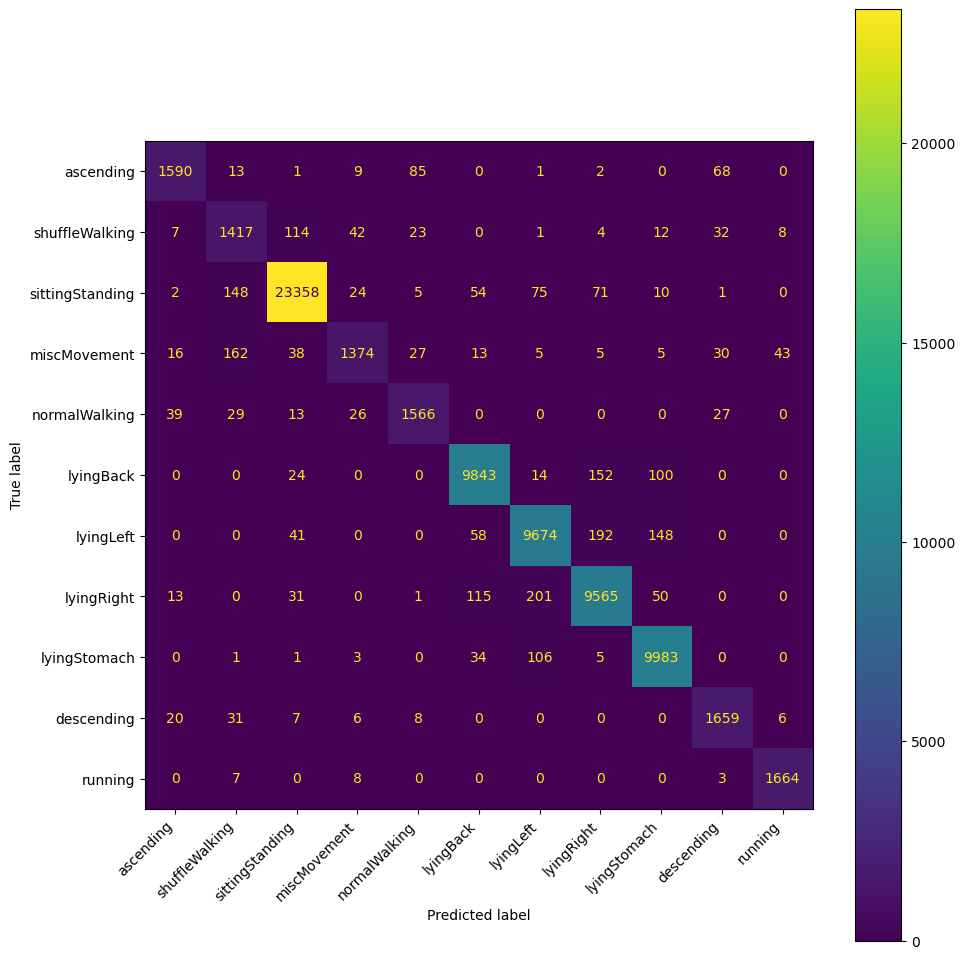

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Convert the lists for the confusion matrix to numpy arrays
all_y_true_activity = np.array(all_y_true_activity)
all_y_pred_activity = np.array(all_y_pred_activity)

# Generate confusion matrix
cm = confusion_matrix(all_y_true_activity, all_y_pred_activity)
disp = ConfusionMatrixDisplay(cm, display_labels=activity_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
disp.plot(ax=ax, cmap='viridis')

# Rotate the x-axis labels and adjust spacing
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Step 4: Evaluate the Model
After training, you can evaluate the model on the test set:

In [44]:
'''
# Get predicted probabilities for the test set
y_pred_probs = model.predict(X_test)

# Convert the predicted probabilities to class labels (taking the argmax of the probabilities)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert the true test labels from one-hot encoding back to class labels
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print the classification report
print(report)
'''

'\n# Get predicted probabilities for the test set\ny_pred_probs = model.predict(X_test)\n\n# Convert the predicted probabilities to class labels (taking the argmax of the probabilities)\ny_pred_classes = np.argmax(y_pred_probs, axis=1)\n\n# Convert the true test labels from one-hot encoding back to class labels\ny_true_classes = np.argmax(y_test_one_hot, axis=1)\n\n# Generate the classification report\nreport = classification_report(y_true_classes, y_pred_classes, digits=4)\n\n# Print the classification report\nprint(report)\n'

As you can see from the model performance results, the classification performance isn't exactly impressive. For Coursework 3, your group should explore and experiment with various models, parameters, and techniques in order to improve your model's performance.

# Exporting your model to TFLite

You can use the TFLiteConverter class provided by TensorFlow to convert your trained model into the TensorFlow Lite format. We export models to TensorFlow Lite (TFLite) for several reasons, primarily because TFLite is designed for deployment on edge devices, such as mobile phones, embedded systems, IoT devices, and microcontrollers, where computational resources and power are limited. This is necessary as you will be running your ML models on your Android devices to perform live classification.

In [45]:
# Convert the trained Keras model to TensorFlow Lite format
activity_converter = tf.lite.TFLiteConverter.from_keras_model(activity_model)  # model is your trained Keras model
tflite_activity_model = activity_converter.convert()

social_signal_converter = tf.lite.TFLiteConverter.from_keras_model(social_signal_model)  # model is your trained Keras model
tflite_social_signal_model = social_signal_converter.convert()


# Save the converted model to a .tflite file
with open('activity_model.tflite', 'wb') as f:
    f.write(tflite_activity_model)

print("Activity model saved to activity_model.tflite")

with open('social_signal_model.tflite', 'wb') as f:
    f.write(tflite_social_signal_model)

print("Social signal model saved to social_signal_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmp8l7v_hsy\assets


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmp8l7v_hsy\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmp8l7v_hsy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_1064')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  1366533180496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533177616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533183568: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:t

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmp1px920d1\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmp1px920d1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_784')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1366661218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662115984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662112912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662117904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662116560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Activity

# Good job!
This is the end of Lab 3. In the next lab, you will focus on deploying your machine learning model onto your Android App in order to classify activities in real-time.

In [46]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

def evaluate_tflite_model(tflite_model_path, X_val, y_val_one_hot):
    # Load TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Run inference on each validation sample
    predictions = []
    for i in range(len(X_val)):
        # Preprocess input
        input_data = np.expand_dims(X_val[i], axis=0).astype(np.float32)
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run the inference
        interpreter.invoke()
        
        # Get the output tensor and store the prediction
        output_data = interpreter.get_tensor(output_details[0]['index'])
        pred_class = np.argmax(output_data)
        predictions.append(pred_class)
    
    # Convert one-hot encoded labels to class labels
    y_true = np.argmax(y_val_one_hot, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, predictions)
    
    # Print the classification report
    report = classification_report(y_true, predictions, digits=4)
    
    return accuracy, report


In [47]:
fold_no = 1
activity_accuracies = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the activity TFLite model for each fold
for train_index, val_index in kfold.split(X_activity):
    # Split the validation set for this fold
    X_val_fold_activity, y_val_fold_activity = X_activity[val_index], y_activity_one_hot[val_index]
    
    # Export and evaluate TFLite model for activity classification
    activity_tflite_path = f'activity_model_fold_{fold_no}.tflite'
    activity_converter = tf.lite.TFLiteConverter.from_keras_model(activity_model)
    tflite_activity_model = activity_converter.convert()
    with open(activity_tflite_path, 'wb') as f:
        f.write(tflite_activity_model)
        
    # Test accuracy of the activity TFLite model
    activity_accuracy, activity_report = evaluate_tflite_model(activity_tflite_path, X_val_fold_activity, y_val_fold_activity)
    activity_accuracies.append(activity_accuracy)
    print(f'Fold {fold_no} - Activity Model Accuracy: {activity_accuracy:.4f}')
    print(activity_report)
    
    fold_no += 1

average_activity_accuracy = np.mean(activity_accuracies)
print(f'Average Activity Model Accuracy across folds: {average_activity_accuracy:.4f}')


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpdr_o4bxx\assets


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpdr_o4bxx\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpdr_o4bxx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_1064')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  1366533180496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533177616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533183568: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 1

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmphbcsyq1w\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmphbcsyq1w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_1064')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  1366533180496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533177616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533183568: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 2

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpteuf7aru\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpteuf7aru'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_1064')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  1366533180496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533177616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533183568: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 3

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpalc9w4b1\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpalc9w4b1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_1064')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  1366533180496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533177616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533183568: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 4

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmp2rh6jnwm\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmp2rh6jnwm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_1064')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  1366533180496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533178768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533177616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533181456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533179152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366533183568: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 5

In [48]:
fold_no = 1
social_signal_accuracies = []

# Evaluate the social signal TFLite model for each fold
for train_index, val_index in kfold.split(X_social_signal):
    # Split the validation set for this fold
    X_val_fold_social_signal, y_val_fold_social_signal = X_social_signal[val_index], y_social_signal_one_hot[val_index]
    
    # Export and evaluate TFLite model for social signal classification
    social_signal_tflite_path = f'social_signal_model_fold_{fold_no}.tflite'
    social_signal_converter = tf.lite.TFLiteConverter.from_keras_model(social_signal_model)
    tflite_social_signal_model = social_signal_converter.convert()
    with open(social_signal_tflite_path, 'wb') as f:
        f.write(tflite_social_signal_model)
        
    # Test accuracy of the social signal TFLite model
    social_signal_accuracy, social_signal_report = evaluate_tflite_model(social_signal_tflite_path, X_val_fold_social_signal, y_val_fold_social_signal)
    social_signal_accuracies.append(social_signal_accuracy)
    print(f'Fold {fold_no} - Social Signal Model Accuracy: {social_signal_accuracy:.4f}')
    print(social_signal_report)
    
    fold_no += 1

average_social_signal_accuracy = np.mean(social_signal_accuracies)
print(f'Average Social Signal Model Accuracy across folds: {average_social_signal_accuracy:.4f}')


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmp_kwmd2pw\assets


INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmp_kwmd2pw\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmp_kwmd2pw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_784')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1366661218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662115984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662112912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662117904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662116560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 1 -

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpopzmhgum\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpopzmhgum'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_784')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1366661218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662115984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662112912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662117904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662116560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 2 -

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmp4budevvy\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmp4budevvy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_784')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1366661218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662115984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662112912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662117904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662116560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 3 -

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmp3afu98mi\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmp3afu98mi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_784')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1366661218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662115984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662112912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662117904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662116560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 4 -

INFO:tensorflow:Assets written to: C:\Users\seanc\AppData\Local\Temp\tmpwekxcuxi\assets


Saved artifact at 'C:\Users\seanc\AppData\Local\Temp\tmpwekxcuxi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='keras_tensor_784')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1366661218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662115984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662112912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662103504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662117904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662114640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366662116560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Fold 5 -